# Figure showing if models that better simulate the peak paradox trends have different future trends

Plot 2015-2100 trend vs. 1986-2004 trend. Note, this requires the raw SSP2.45 precipitation files, which are too large to include in the repository, but can be downloaded from the ESGF.

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import re
import glob
from matplotlib import pyplot as plt
import matplotlib as mpl

from funcs_load import load_raws
from funcs_support import get_filepaths,get_params,subset_to_srat,area_mean,utility_print
dir_list = get_params()

In [18]:
# Load historical trends
dss = {exp:load_raws({'varname':'prtrends','suffix':'HoAfrica',
                 'exp':exp},subset_params = {'start_year':slice(1979,1990),
                                                       'end_year':slice(2000,2014)},
                source_dir = 'proc',force_load = True)
       for exp in ['obs','hist-ssp245']}
# Concat into single ds
for exp in dss:
    dss[exp] = xr.concat([ds.expand_dims({'model':[mod]}).stack(idv = ['model','run'])
               for mod,ds in dss[exp].items() if ds.sizes['start_year']!=0],
              dim='idv')

In [19]:
# Get SSP2.45 files
df = get_filepaths()
df = df.query('varname == "pr" and freq == "Amon" and suffix == "HoAfrica" and exp == "ssp245"')

dssf = [None]*len(df)
for row,row_idx in zip(df.iterrows(),range(len(df))):
    # Load future files
    ds_tmp = xr.open_dataset(row[1]['path'])
    # Get study area means, MAM data
    ds_tmp = area_mean(subset_to_srat(ds_tmp.isel(time = (ds_tmp.time.dt.season == 'MAM'))))

    # Get annual means
    ds_tmp = ds_tmp.resample({'time':'1YE'}).mean()
    ds_tmp['time'] = ds_tmp.time.dt.year
    ds_tmp = ds_tmp.rename({'time':'year'})

    # Stack by model-run
    dssf[row_idx] = ds_tmp.expand_dims({'model':[row[1]['model']],'run':[row[1]['run']]}).stack(idv = ['model','run'])

# Concatenate into single ds
dssf = xr.concat(dssf,dim='idv')

# Convert to mm/day from kg/m^2s
dssf['pr'] = dssf['pr'] * 60 * 60 * 24

# Get linear trends
ddssfm = dssf.drop_duplicates('idv').unstack().polyfit(dim='year',deg=1).sel(degree=1).rename({'pr_polyfit_coefficients':'prtrend_future'}).stack(idv=['model','run'])
ddssfm = ddssfm.dropna('idv')

# Merge with historical data
dss,dsso = xr.merge([dss['hist-ssp245'],ddssfm],join='inner'),dss['obs']

## Figure

/home/kschwarz/projects/future_stability/figures/figureS19.pdf saved!
/home/kschwarz/projects/future_stability/figures/figureS19.png saved!


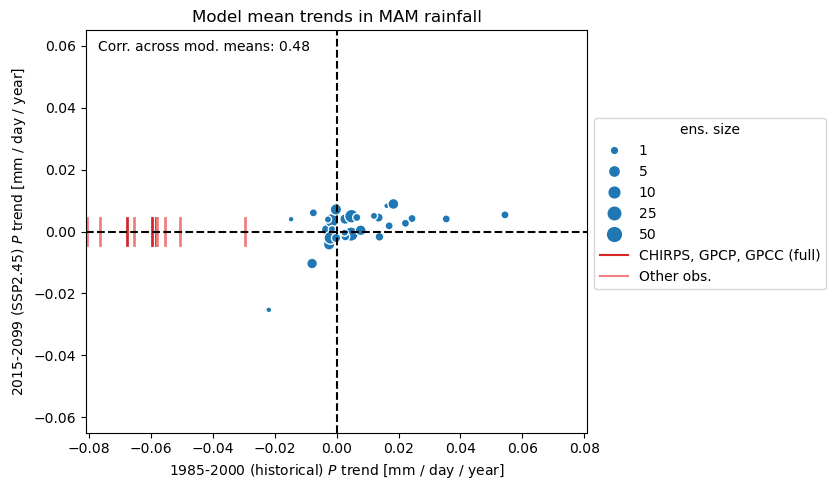

In [51]:
save_fig = True
output_fn = dir_list['figs']+'figureS19'

ylims = [-0.045,0.045]

trend_params = {'start_year':1985,'end_year':2000}

fig = plt.figure(figsize=(8.5,5))

ax = plt.subplot()

plot_data = dss.sel(season='MAM',region='HoA-bimod',**trend_params)
plot_data_obs = dsso.sel(**trend_params,region='HoA-bimod',season='MAM')
obs_mods = ['CHIRPS','GPCP','GPCC-full']

# Get number of runs
counts = plot_data.groupby(plot_data.model).count().prtrend

# Get mean by run
plot_data = plot_data.groupby(plot_data.model).mean()

# Get correlation across model means
corr = xr.corr(plot_data.prtrend,plot_data.prtrend_future,dim='model')

# Plot model means
sc = plot_data.plot.scatter(x='prtrend',y='prtrend_future',s=np.log(counts+1)*25,c='tab:blue')

# Plot historical obs trends
for mod_idx in range(plot_data_obs.sizes['idv']):
    if plot_data_obs.model[mod_idx].values in obs_mods:
        color = 'tab:red'
    else:
        color='lightcoral'
    ax.plot([plot_data_obs.prtrend[mod_idx]]*2,
        [-0.1*ylims[1],0.1*ylims[1]],
        linewidth=2,color=color)

# Create legend - note the `np.sqrt()` call, because `Line2D`'s markersize uses different units from 
# `plt.scatter`'s s parameter.  
ax.legend(handles=[*[mpl.lines.Line2D([0,0],[0,0],linestyle='None',marker='o',
                                      markersize=np.sqrt(np.log(x+1)*25),label=str(x))
                         for x in [1,5,10,25,50]],
                   mpl.lines.Line2D([0,0],[0,0],color='tab:red',label='CHIRPS, GPCP, GPCC (full)'),
                   mpl.lines.Line2D([0,0],[0,0],color='lightcoral',label='Other obs.')],
                   title='ens. size',
          bbox_to_anchor=(1,0.8))

ax.set_xlabel(str(trend_params['start_year'])+'-'+str(trend_params['end_year'])+r' (historical) $P$ trend [mm / day / year]')
ax.set_ylabel(r'2015-2099 (SSP2.45) $P$ trend [mm / day / year]')
ax.set_title('Model mean trends in MAM rainfall')

ax.axhline(0,color='k',linestyle='--')
ax.axvline(0,color='k',linestyle='--')

ax.set_ylim(-0.065,0.065)
ax.set_xlim(-0.081,0.081)
ax.set_aspect('equal')

ax.annotate('Corr. across mod. means: '+str(np.round(corr.values,2)),(0.025,0.975),ha='left',va='top',xycoords='axes fraction')
#plt.show()

plt.tight_layout()
if save_fig:
    utility_print(output_fn)